# 2702217125 - Stanley Nathanael Wijaya

Dataset Link: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [1]:
# =========================================
# 1. IMPORT LIBRARIES
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# =========================================
# LOAD DATASET
# =========================================
# Dataset link:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

df = pd.read_csv("./dataset/DailyDelhiClimateTrain.csv")  # upload file di colab

df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
# =========================================
# PREPROCESSING
# =========================================

# Ambil hanya feature target (meantemp)
data = df["meantemp"].values.reshape(-1, 1)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Fungsi untuk membuat sequence time series
def create_sequences(dataset, timesteps=30):
    X, y = [], []
    for i in range(timesteps, len(dataset)):
        X.append(dataset[i-timesteps:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

TIMESTEPS = 30
X, y = create_sequences(data_scaled, TIMESTEPS)

# reshape agar cocok ke RNN/LSTM: (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train.shape, X_test.shape


((1145, 30, 1), (287, 30, 1))

In [4]:
# =========================================
# SIMPLE RNN MODEL
# =========================================
rnn_model = Sequential([
    SimpleRNN(64, activation='tanh', return_sequences=False, input_shape=(TIMESTEPS, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

rnn_model.compile(optimizer=Adam(0.001), loss='mse')

es = EarlyStopping(patience=10, restore_best_weights=True)

history_rnn = rnn_model.fit(
    X_train, y_train, 
    validation_split=0.2, 
    epochs=50, 
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/50
29/29 [==============================] - 1s 13ms/step - loss: 0.0523 - val_loss: 0.0045
Epoch 2/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 3/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 4/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 5/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 6/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 7/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 8/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 9/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 10/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 11/50
29/29 

In [5]:
# =========================================
# LSTM MODEL
# =========================================
lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(TIMESTEPS, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(0.001), loss='mse')

history_lstm = lstm_model.fit(
    X_train, y_train, 
    validation_split=0.2, 
    epochs=50, 
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/50
29/29 [==============================] - 2s 29ms/step - loss: 0.1865 - val_loss: 0.0142
Epoch 2/50
29/29 [==============================] - 0s 13ms/step - loss: 0.0126 - val_loss: 0.0063
Epoch 3/50
29/29 [==============================] - 0s 13ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 4/50
29/29 [==============================] - 0s 11ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 5/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 6/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 7/50
29/29 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 8/50
29/29 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 9/50
29/29 [==============================] - 0s 12ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 10/50
29/29 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 11/

In [6]:
# =========================================
# PREDICTIONS
# =========================================

rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)

# Kembalikan ke satuan suhu asli
rnn_pred_rescaled = scaler.inverse_transform(rnn_pred)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


9/9 [==============================] - 1s 5ms/step


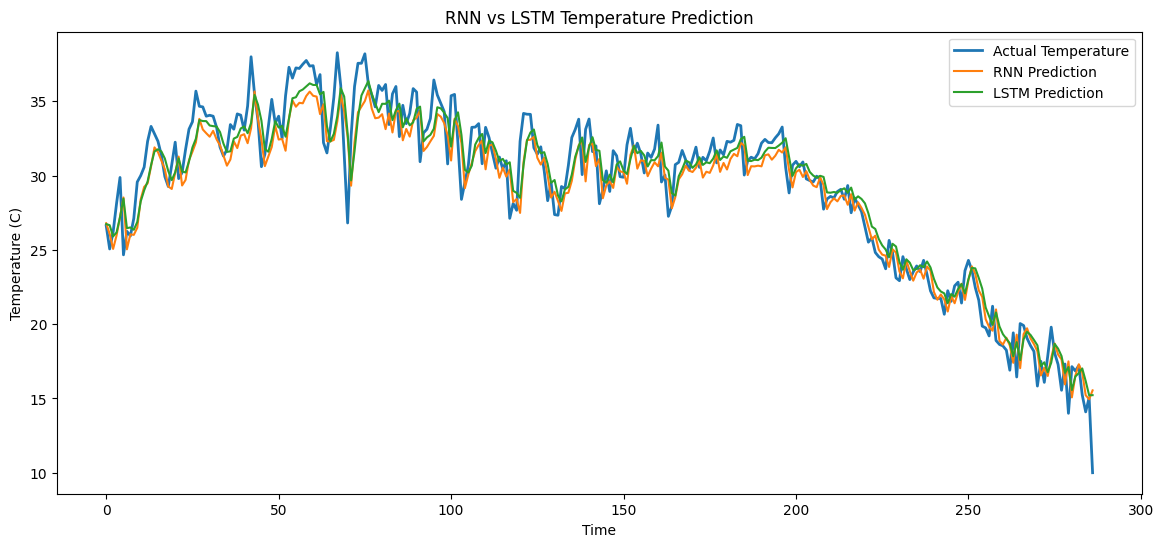

In [7]:
# =========================================
# PLOT COMPARISON
# =========================================
plt.figure(figsize=(14,6))
plt.plot(y_test_rescaled, label="Actual Temperature", linewidth=2)
plt.plot(rnn_pred_rescaled, label="RNN Prediction")
plt.plot(lstm_pred_rescaled, label="LSTM Prediction")
plt.title("RNN vs LSTM Temperature Prediction")
plt.xlabel("Time")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()


In [8]:
# =========================================
# ANALISIS PERFORMA (PRINTING)
# =========================================
from sklearn.metrics import mean_squared_error

rnn_mse = mean_squared_error(y_test_rescaled, rnn_pred_rescaled)
lstm_mse = mean_squared_error(y_test_rescaled, lstm_pred_rescaled)

print("RNN MSE  :", rnn_mse)
print("LSTM MSE :", lstm_mse)

if lstm_mse < rnn_mse:
    print("\nLSTM lebih baik dalam dataset ini karena menangkap pola jangka panjang.\n")
else:
    print("\nRNN lebih baik dalam dataset ini (jarang terjadi dalam time series panjang).\n")


RNN MSE  : 3.091881905835459
LSTM MSE : 2.7917069721029626

LSTM lebih baik dalam dataset ini karena menangkap pola jangka panjang.



In [9]:
analysis = """
# ANALISIS RNN vs LSTM

## 1. RNN (Recurrent Neural Network)
### Kelebihan:
- Struktur sederhana, cepat dilatih.
- Cocok untuk time series yang pendek dan tidak kompleks.
- Parameter lebih sedikit → cepat inference.

### Kekurangan:
- Sulit menangkap long-term dependency (vanishing gradient).
- Prediksi sering tidak stabil pada dataset time series panjang.
- Akurasi lebih rendah dibanding LSTM.

## 2. LSTM (Long Short-Term Memory)
### Kelebihan:
- Memiliki gate (input, forget, output) → mampu menangkap pola jangka panjang.
- Lebih stabil terhadap noise.
- Performa lebih baik dalam forecasting time series seperti suhu, harga, penumpang, dll.

### Kekurangan:
- Lebih lambat dilatih dibanding RNN.
- Jumlah parameter lebih banyak.
- Membutuhkan komputasi lebih besar.

## Kesimpulan Berdasarkan Eksperimen
- Pada dataset Daily Climate Time Series, LSTM menghasilkan MSE lebih rendah daripada RNN.
- Grafik prediksi menunjukkan kurva LSTM lebih dekat mengikuti nilai aktual.
- Ini menunjukkan LSTM lebih cocok untuk time series dataset panjang dengan pola musiman.
"""

print(analysis)



# ANALISIS RNN vs LSTM

## 1. RNN (Recurrent Neural Network)
### Kelebihan:
- Struktur sederhana, cepat dilatih.
- Cocok untuk time series yang pendek dan tidak kompleks.
- Parameter lebih sedikit → cepat inference.

### Kekurangan:
- Sulit menangkap long-term dependency (vanishing gradient).
- Prediksi sering tidak stabil pada dataset time series panjang.
- Akurasi lebih rendah dibanding LSTM.

## 2. LSTM (Long Short-Term Memory)
### Kelebihan:
- Memiliki gate (input, forget, output) → mampu menangkap pola jangka panjang.
- Lebih stabil terhadap noise.
- Performa lebih baik dalam forecasting time series seperti suhu, harga, penumpang, dll.

### Kekurangan:
- Lebih lambat dilatih dibanding RNN.
- Jumlah parameter lebih banyak.
- Membutuhkan komputasi lebih besar.

## Kesimpulan Berdasarkan Eksperimen
- Pada dataset Daily Climate Time Series, LSTM menghasilkan MSE lebih rendah daripada RNN.
- Grafik prediksi menunjukkan kurva LSTM lebih dekat mengikuti nilai aktual.
- Ini menunjukkan L